### Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from sklearn.cluster import KMeans
import reverse_geocode
import networkx as nx
from itertools import combinations

### Data Cleaning

In [2]:
file_path = 'globalterrorismdb.csv'
data = pd.read_csv(file_path, encoding='ISO-8859-1', low_memory=False)
missing_data_percentage = data.isnull().mean() * 100
columns_to_drop_due_to_missing_data = missing_data_percentage[missing_data_percentage > 50].index
additional_columns_to_drop = ['ï»¿eventid', 'vicinity', 'claimed', 'nkillter', 'nwoundte', 'property', 'scite1', 'dbsource']
all_columns_to_drop = list(columns_to_drop_due_to_missing_data) + additional_columns_to_drop
data_cleaned = data.drop(columns=all_columns_to_drop)


data_cleaned['nperps'] = pd.to_numeric(data_cleaned['nperps'], errors='coerce')
data_cleaned['nperpcap'] = pd.to_numeric(data_cleaned['nperpcap'], errors='coerce')
data_cleaned['nperps'].fillna(0, inplace=True)
data_cleaned['nperps'].replace(-99, 0, inplace=True)
data_cleaned['nperpcap'].fillna(0, inplace=True)
data_cleaned['nperpcap'].replace(-99, 0, inplace=True)
data['iyear'] = data['iyear'].astype(str)
data['imonth'] = data['imonth'].astype(str).str.zfill(2)
data['iday'] = data['iday'].astype(str).str.zfill(2)
data['imonth'] = data['imonth'].replace('00', '01')
data['iday'] = data['iday'].replace('00', '01')
data['date'] = pd.to_datetime(data['iyear'] + '-' + data['imonth'] + '-' + data['iday'])
data['day_of_week'] = data['date'].dt.day_name()
data['total_casualties'] = data['nkill'].fillna(0) + data['nwound'].fillna(0)
data['total_us_casualties'] = data['nkillus'].fillna(0) + data['nwoundus'].fillna(0)
data.drop(columns=['iyear', 'imonth', 'iday'], inplace=True)

output_file_path = 'cleaned_globalterrorismdb.csv'
data_cleaned.to_csv(output_file_path, index=False, encoding='utf-8-sig')

### Data Integration

In [3]:
main_df = pd.read_csv("cleaned_globalterrorismdb.csv")
gdp_df = pd.read_csv("GDP_dataset.csv")
gdp_df = gdp_df.melt(id_vars=["Country Name", "Country Code", "Series Name", "Series Code"],var_name="Year", value_name="GDP")
gdp_df['Year'] = gdp_df['Year'].str.extract('(\d+)')
gdp_df.dropna(subset=['Year', 'GDP'], inplace=True)
gdp_df['Year'] = gdp_df['Year'].astype(int)

def get_gdp(country, year):
    gdp_value = gdp_df[(gdp_df['Country Name'] == country) & (gdp_df['Year'] == year)]['GDP']
    return gdp_value.iloc[0] if not gdp_value.empty else None
main_df['GDP'] = main_df.apply(lambda row: get_gdp(row['country_txt'], row['iyear']), axis=1)

main_df.to_csv("updated_main_dataset.csv", index=False)

### Temporal Analysis

/tmp/ipykernel_1025/4035301874.py:1: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('updated_main_dataset.csv')


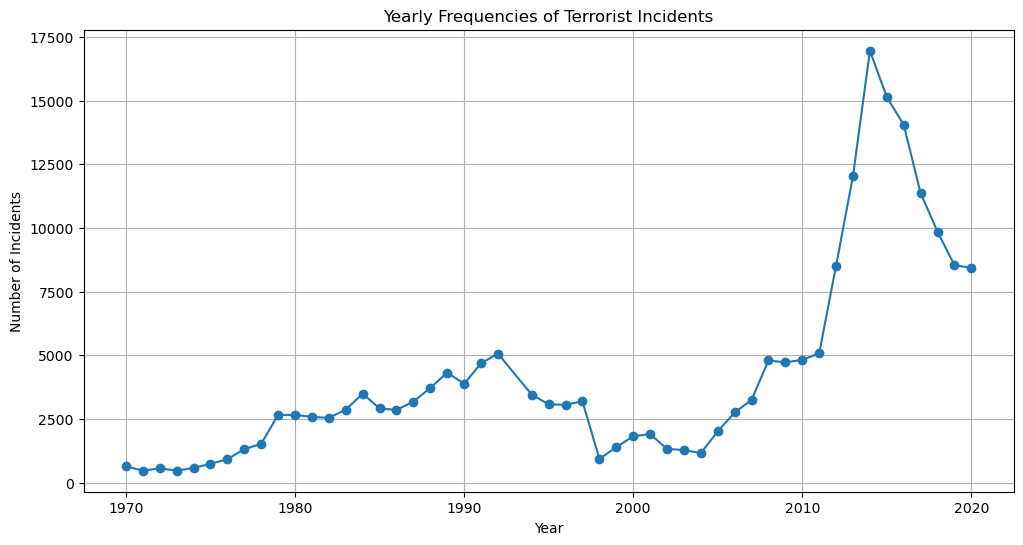

Kendall's tau: 0.572
The trend is statistically significant.


In [4]:
df = pd.read_csv('updated_main_dataset.csv')

yearly_counts = df['iyear'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
yearly_counts.plot(kind='line', marker='o')
plt.title('Yearly Frequencies of Terrorist Incidents')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.grid(True)
plt.show()

tau, p_value = kendalltau(yearly_counts.index, yearly_counts.values)

print(f"Kendall's tau: {tau:.3f}")
if p_value < 0.05:
    print("The trend is statistically significant.")
else:
    print("The trend is not statistically significant.")


In [5]:
df = pd.read_csv('updated_main_dataset.csv')

unique_regions = df['region_txt'].unique()
print("Unique Regions:")
for region in unique_regions:
    print(region)

/tmp/ipykernel_1025/3483874653.py:1: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('updated_main_dataset.csv')


Unique Regions:
Central America & Caribbean
North America
Southeast Asia
Western Europe
East Asia
South America
Eastern Europe
Sub-Saharan Africa
Middle East & North Africa
Australasia & Oceania
South Asia
Central Asia


/tmp/ipykernel_1025/4583844.py:1: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('updated_main_dataset.csv')


Global - Kendall's tau: 0.572, p-value: 4.52e-09
Central America & Caribbean - Kendall's tau: -0.349, p-value: 0.000457
North America - Kendall's tau: -0.313, p-value: 0.00135
Southeast Asia - Kendall's tau: 0.706, p-value: 4.63e-13
Western Europe - Kendall's tau: -0.336, p-value: 0.000586
East Asia - Kendall's tau: 0.131, p-value: 0.196
South America - Kendall's tau: 0.033, p-value: 0.732
Eastern Europe - Kendall's tau: 0.535, p-value: 1.03e-07
Sub-Saharan Africa - Kendall's tau: 0.643, p-value: 4.59e-11
Middle East & North Africa - Kendall's tau: 0.707, p-value: 4.35e-13
Australasia & Oceania - Kendall's tau: 0.181, p-value: 0.0997
South Asia - Kendall's tau: 0.751, p-value: 3.04e-14
Central Asia - Kendall's tau: -0.453, p-value: 0.000661


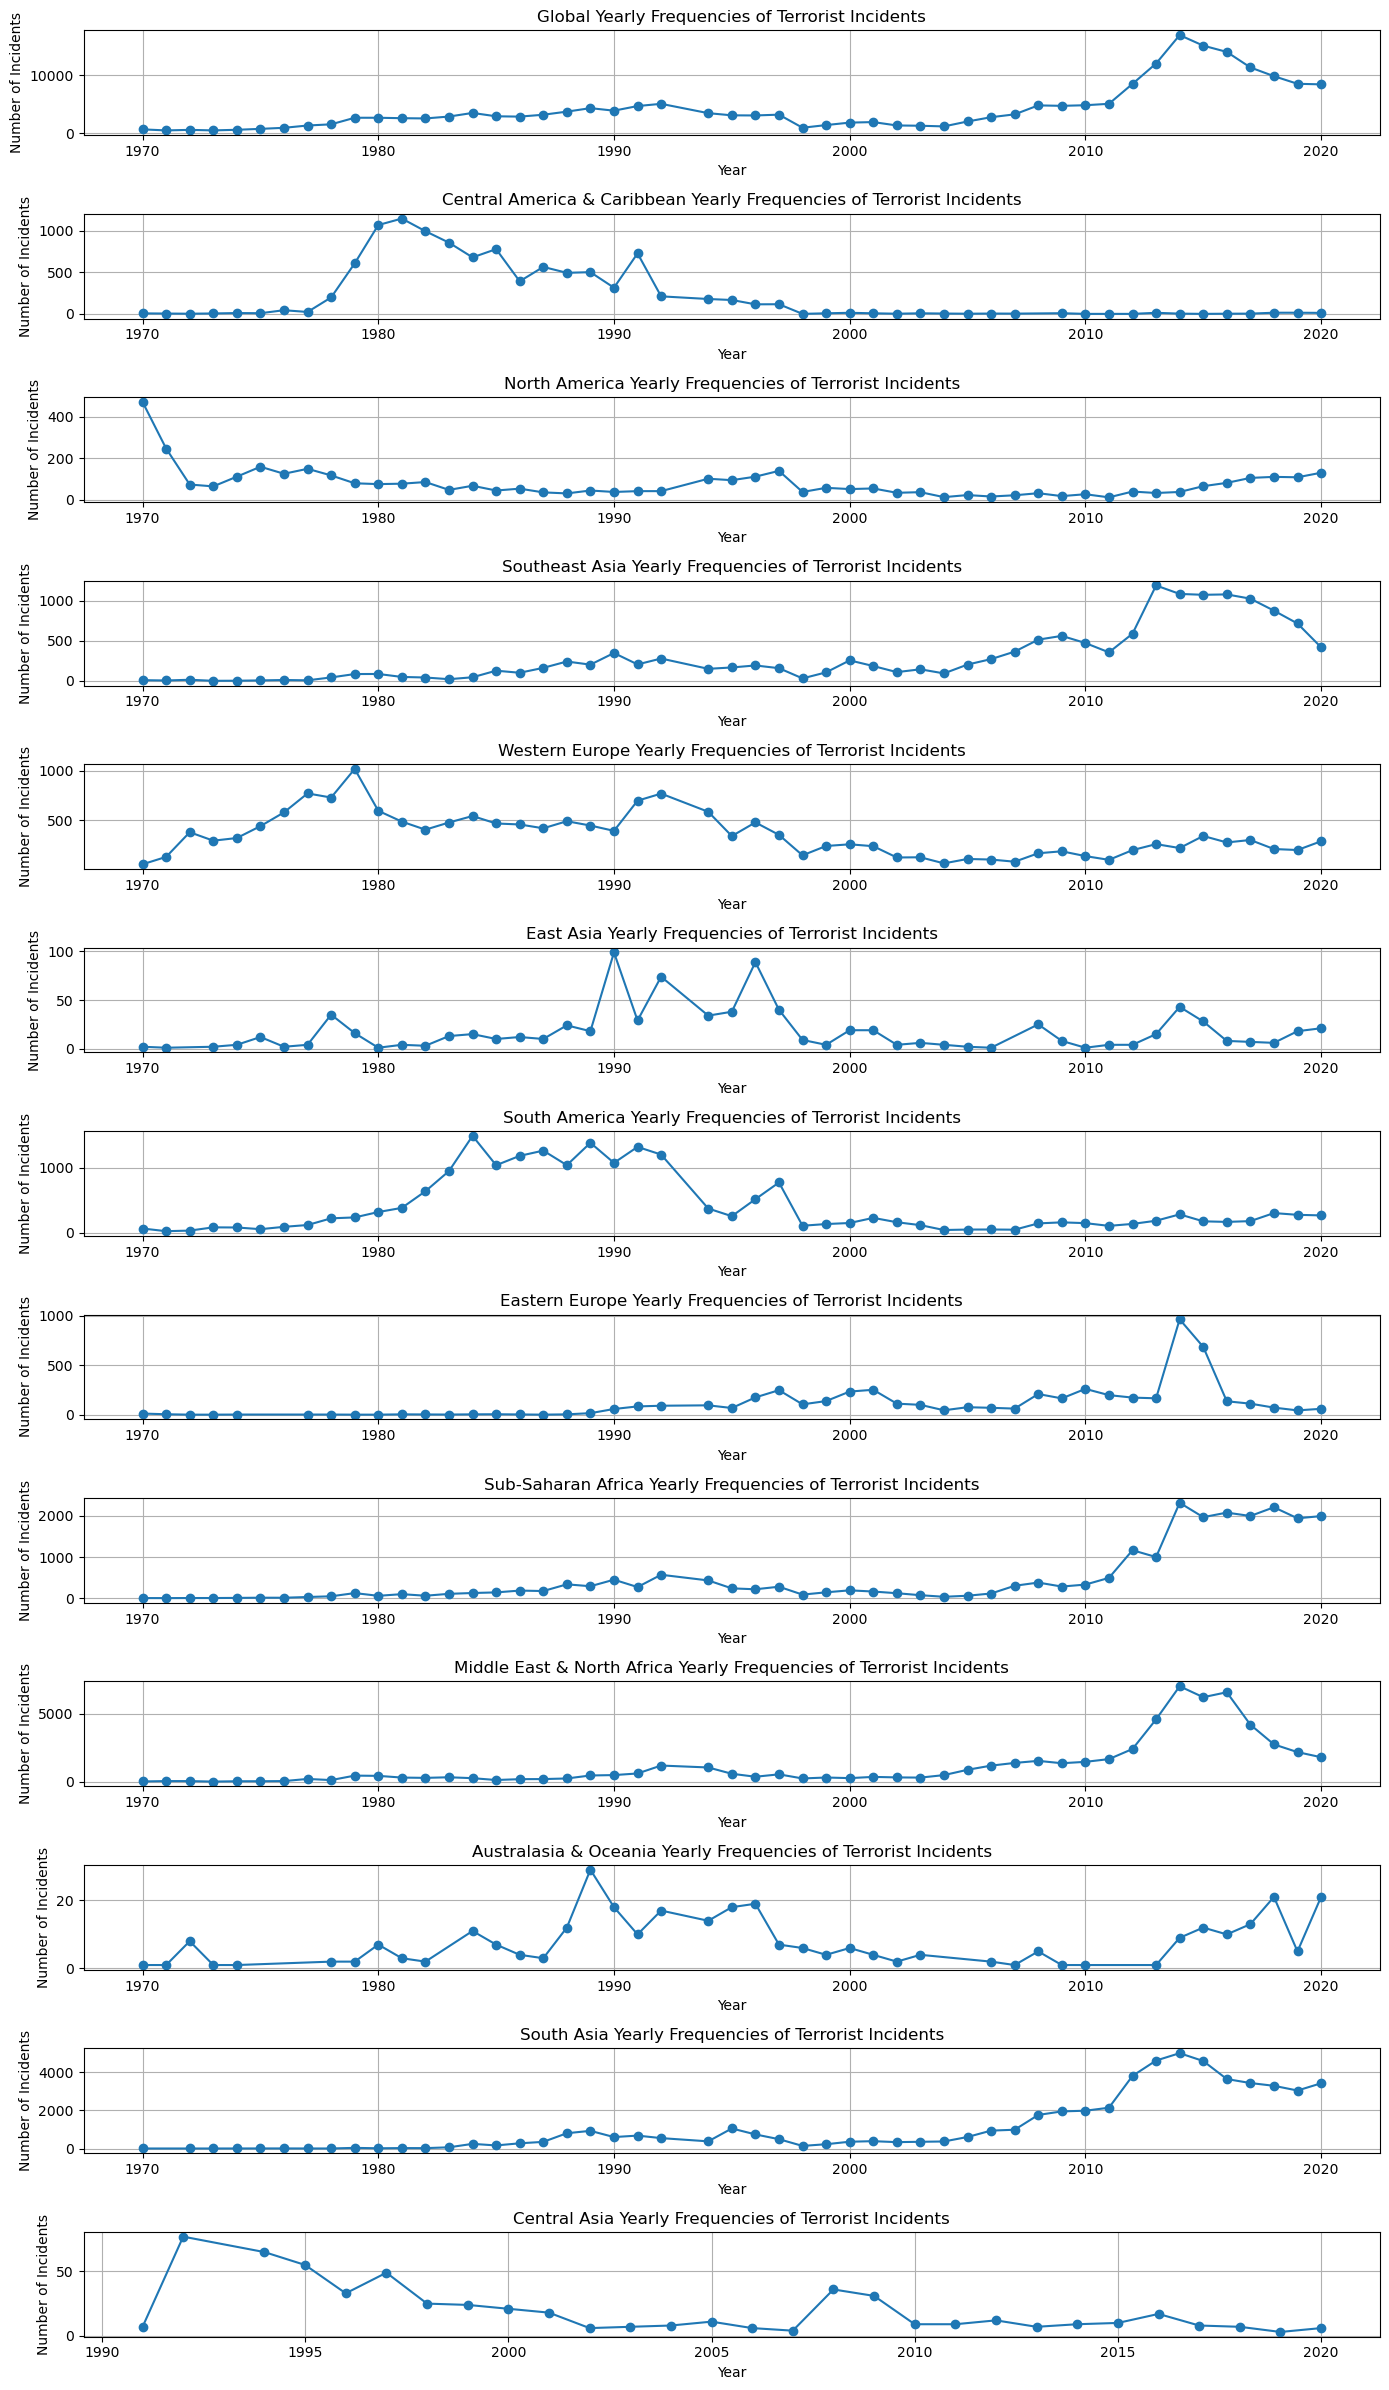

In [6]:
df = pd.read_csv('updated_main_dataset.csv')

regions = [
    'Central America & Caribbean', 'North America', 'Southeast Asia',
    'Western Europe', 'East Asia', 'South America', 'Eastern Europe',
    'Sub-Saharan Africa', 'Middle East & North Africa', 'Australasia & Oceania',
    'South Asia', 'Central Asia'
]

plt.figure(figsize=(14, 24))

plt.subplot(len(regions) + 1, 1, 1)
global_yearly_counts = df['iyear'].value_counts().sort_index()
global_yearly_counts.plot(kind='line', marker='o')
plt.title('Global Yearly Frequencies of Terrorist Incidents')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.grid(True)

tau, p_value = kendalltau(global_yearly_counts.index, global_yearly_counts.values)
print(f"Global - Kendall's tau: {tau:.3f}, p-value: {p_value:.3g}")

for i, region in enumerate(regions, start=2):
    plt.subplot(len(regions) + 1, 1, i)
    region_df = df[df['region_txt'] == region]
    yearly_counts = region_df['iyear'].value_counts().sort_index()
    yearly_counts.plot(kind='line', marker='o')
    plt.title(f'{region} Yearly Frequencies of Terrorist Incidents')
    plt.xlabel('Year')
    plt.ylabel('Number of Incidents')
    plt.grid(True)
    
    tau, p_value = kendalltau(yearly_counts.index, yearly_counts.values)
    print(f"{region} - Kendall's tau: {tau:.3f}, p-value: {p_value:.3g}")

plt.tight_layout()
plt.show()

### Spatial Analysis

/tmp/ipykernel_1025/1830247214.py:1: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('updated_main_dataset.csv')
/tmp/ipykernel_1025/1830247214.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


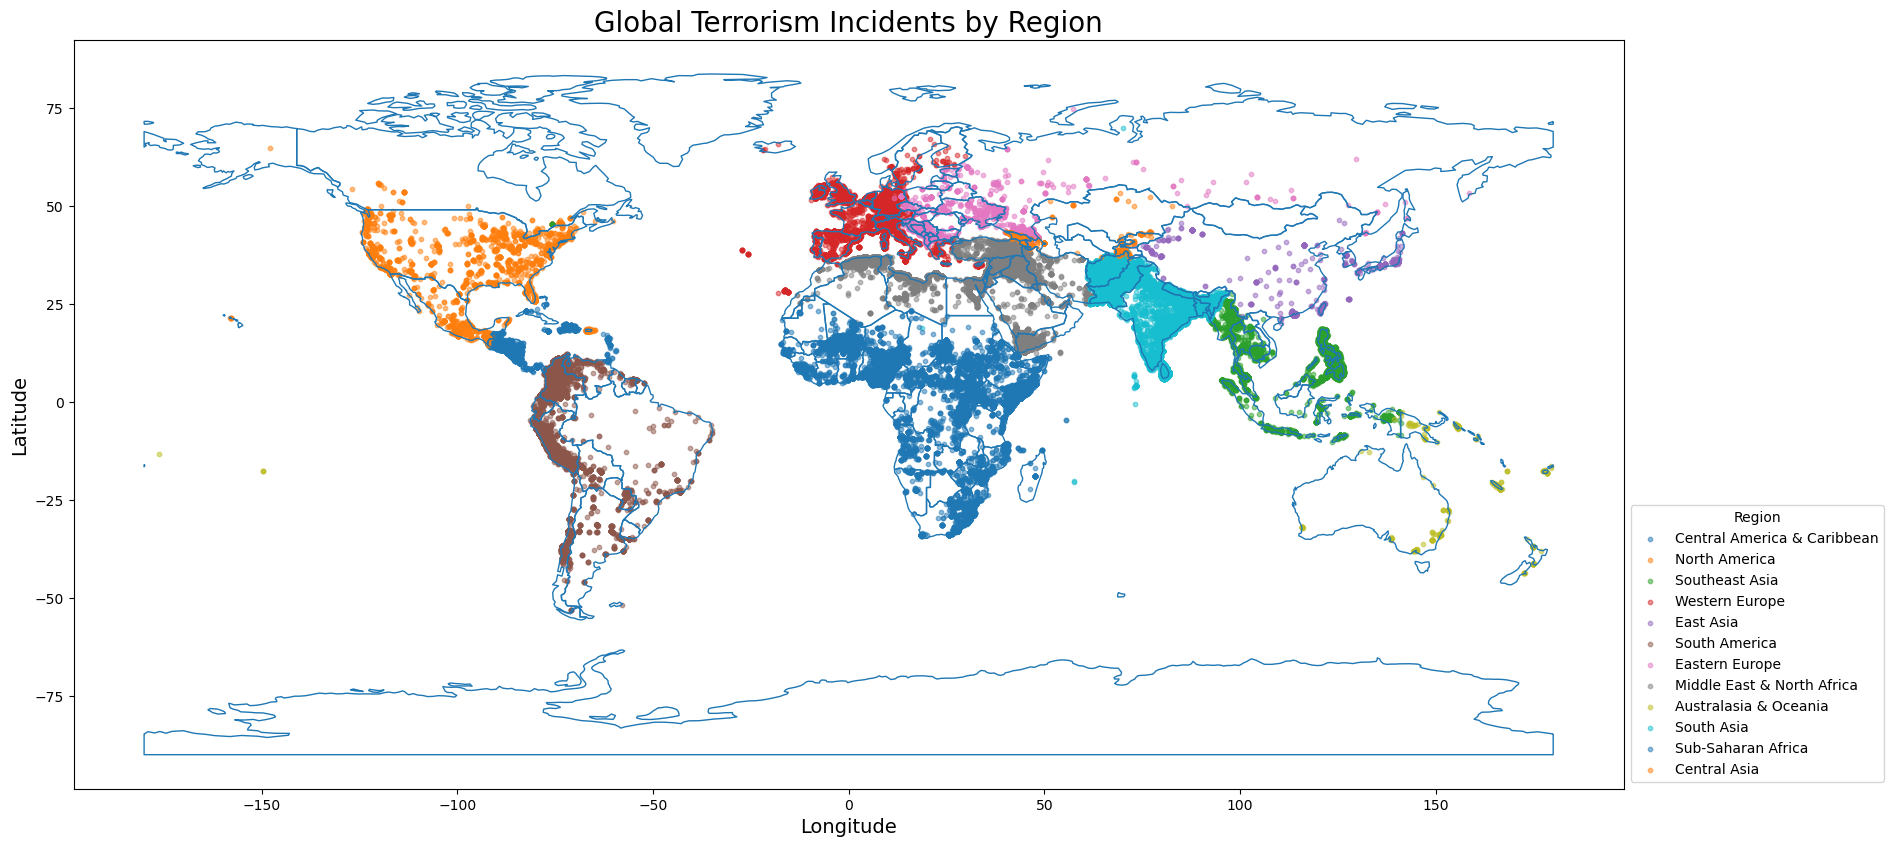

In [7]:
df = pd.read_csv('updated_main_dataset.csv')
df = df.dropna(subset=['latitude', 'longitude'])
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(20, 10))
world.boundary.plot(ax=ax, linewidth=1)

regions = df['region_txt'].unique()
for region in regions:
    regional_data = df[df['region_txt'] == region]
    ax.scatter(regional_data['longitude'], regional_data['latitude'], 
               s=10, label=region, alpha=0.5)

ax.set_title('Global Terrorism Incidents by Region', fontsize=20)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.legend(title='Region', loc='lower left', bbox_to_anchor=(1, 0))

plt.show()

In [8]:
df = pd.read_csv('updated_main_dataset.csv')
df = df.dropna(subset=['nkill'])

region_aggregate = df.groupby('region_txt')['nkill'].sum().reset_index()
region_aggregate_sorted = region_aggregate.sort_values(by='nkill', ascending=False)

print(region_aggregate_sorted)

/tmp/ipykernel_1025/3909883325.py:1: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('updated_main_dataset.csv')


                     region_txt     nkill
5    Middle East & North Africa  149739.0
8                    South Asia  132037.0
10           Sub-Saharan Africa  100557.0
7                 South America   29388.0
1   Central America & Caribbean   28730.0
9                Southeast Asia   17109.0
4                Eastern Europe    7483.0
11               Western Europe    6709.0
6                 North America    5153.0
3                     East Asia    1154.0
2                  Central Asia    1084.0
0         Australasia & Oceania     205.0


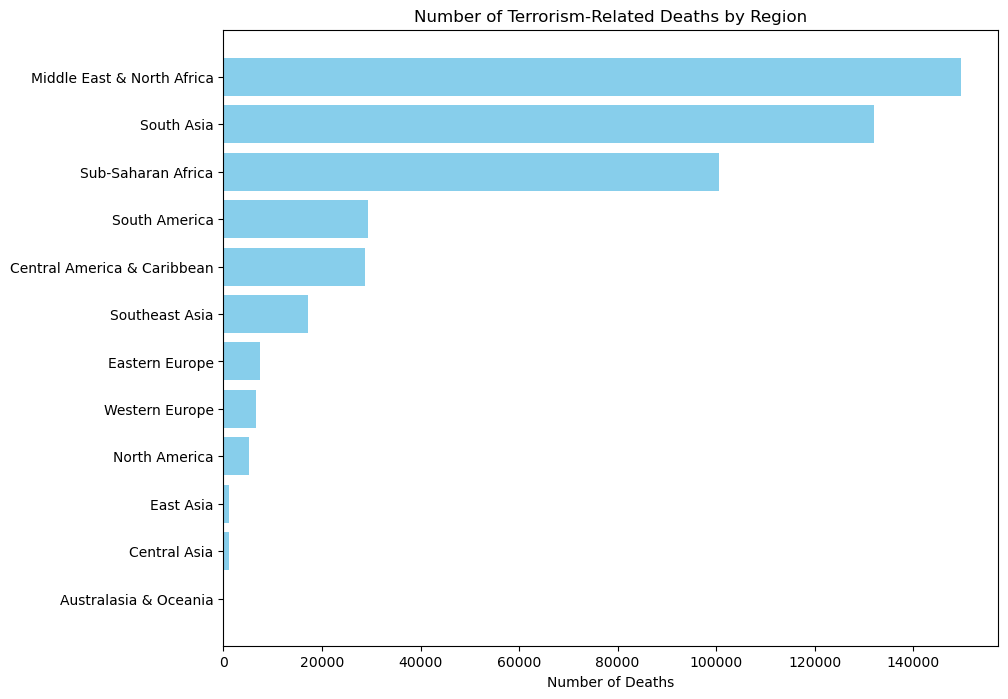

In [9]:
data = {
    'region_txt': [
        'Middle East & North Africa', 'South Asia', 'Sub-Saharan Africa',
        'South America', 'Central America & Caribbean', 'Southeast Asia',
        'Eastern Europe', 'Western Europe', 'North America',
        'East Asia', 'Central Asia', 'Australasia & Oceania'
    ],
    'nkill': [
        149739.0, 132037.0, 100557.0, 29388.0, 28730.0, 17109.0,
        7483.0, 6709.0, 5153.0, 1154.0, 1084.0, 205.0
    ]
}

df = pd.DataFrame(data)
df_sorted = df.sort_values(by='nkill', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(df_sorted['region_txt'], df_sorted['nkill'], color='skyblue')
plt.xlabel('Number of Deaths')
plt.title('Number of Terrorism-Related Deaths by Region')
plt.gca().invert_yaxis()
plt.show()

/tmp/ipykernel_1025/962206952.py:1: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('updated_main_dataset.csv')


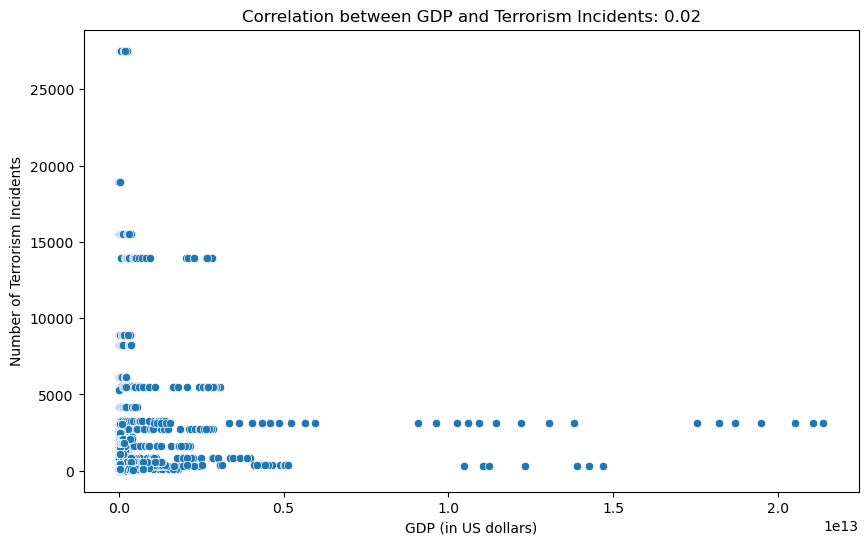

In [10]:
df = pd.read_csv('updated_main_dataset.csv')
df['GDP'] = pd.to_numeric(df['GDP'], errors='coerce')

incident_counts = df.groupby('country_txt').size().reset_index(name='incident_count')
merged_data = pd.merge(incident_counts, df[['country_txt', 'GDP']].drop_duplicates(), on='country_txt')
merged_data.dropna(subset=['GDP', 'incident_count'], inplace=True)
correlation = merged_data['incident_count'].corr(merged_data['GDP'])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='GDP', y='incident_count')
plt.title(f'Correlation between GDP and Terrorism Incidents: {correlation:.2f}')
plt.xlabel('GDP (in US dollars)')
plt.ylabel('Number of Terrorism Incidents')
plt.show()

In [11]:
df = pd.read_csv('updated_main_dataset.csv')
df['GDP'] = pd.to_numeric(df['GDP'], errors='coerce')

incident_counts = df.groupby(['region_txt', 'country_txt']).size().reset_index(name='incident_count')
merged_data = pd.merge(incident_counts, df[['country_txt', 'GDP']].drop_duplicates(), on='country_txt')
merged_data.dropna(subset=['GDP', 'incident_count'], inplace=True)
aggregate_gdp = merged_data.groupby('region_txt')['GDP'].sum().reset_index()
correlation_by_region = merged_data.groupby('region_txt').apply(lambda x: x['incident_count'].corr(x['GDP'])).reset_index()
correlation_by_region.columns = ['region_txt', 'Correlation']
correlation_gdp_table = pd.merge(correlation_by_region, aggregate_gdp, on='region_txt')

print(correlation_gdp_table)

/tmp/ipykernel_1025/2873928094.py:1: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('updated_main_dataset.csv')


                     region_txt  Correlation           GDP
0         Australasia & Oceania     0.577391  1.366082e+13
1   Central America & Caribbean    -0.083047  1.324589e+12
2                  Central Asia    -0.381046  1.159103e+12
3                     East Asia    -0.335964  1.720731e+14
4                Eastern Europe     0.077744  5.770967e+12
5    Middle East & North Africa    -0.024912  1.862224e+13
6                 North America     0.709317  3.205341e+14
7                 South America    -0.109500  3.682341e+13
8                    South Asia     0.273988  3.240014e+13
9                Southeast Asia    -0.066756  2.120576e+13
10           Sub-Saharan Africa     0.523999  1.365247e+13
11               Western Europe     0.431504  2.343343e+14


In [12]:
df = pd.read_csv('updated_main_dataset.csv')
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
df = df.dropna(subset=['latitude', 'longitude'])

k = 8
kmeans = KMeans(n_clusters=k, random_state=0).fit(df[['latitude', 'longitude']])
df['cluster'] = kmeans.labels_
centroids = kmeans.cluster_centers_
incident_counts = df.groupby('cluster').size().reset_index(name='incident_count')

if 'nkill' in df.columns:
    mean_kills = df.groupby('cluster')['nkill'].mean().reset_index(name='mean_kills')
    cluster_data = pd.merge(incident_counts, mean_kills, on='cluster')
else:
    cluster_data = incident_counts

cluster_data['centroid_latitude'] = centroids[:, 0]
cluster_data['centroid_longitude'] = centroids[:, 1]
cluster_data.sort_values('incident_count', ascending=False, inplace=True)

print(cluster_data)

/tmp/ipykernel_1025/1539358443.py:1: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('updated_main_dataset.csv')
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


   cluster  incident_count  mean_kills  centroid_latitude  centroid_longitude
0        0           55101    2.462421          29.146091           73.739628
2        2           52836    2.540033          35.101332           40.031549
1        1           22310    2.239777          14.084854          -83.258418
5        5           20624    0.964018          45.713947            2.909222
6        6           19147    3.561294           1.885010           39.591381
3        3           14648    1.071843           9.093567          116.497528
4        4           10448    5.349300           9.506583            9.710708
7        7            9900    1.413498         -19.928513          -71.820412


In [13]:
coordinates = [
    (29.146091, 73.739628),
    (35.101332, 40.031549),
    (14.084854, -83.258418),
    (45.713947, 2.909222),
    (1.885010, 39.591381),
    (9.093567, 116.497528),
    (9.506583, 9.710708),
    (-19.928513, -71.820412)
]

countries = reverse_geocode.search(coordinates)

centroid_countries = pd.DataFrame(coordinates, columns=['latitude', 'longitude'])
centroid_countries['country'] = [country['country'] for country in countries]

print(centroid_countries)

    latitude   longitude               country
0  29.146091   73.739628                 India
1  35.101332   40.031549  Syrian Arab Republic
2  14.084854  -83.258418             Nicaragua
3  45.713947    2.909222                France
4   1.885010   39.591381                 Kenya
5   9.093567  116.497528           Philippines
6   9.506583    9.710708               Nigeria
7 -19.928513  -71.820412                 Chile


### Tactic and Weapon Analysis

/tmp/ipykernel_1025/405075031.py:1: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('updated_main_dataset.csv')


           Weapon Type  Frequency
0           Explosives     103475
1             Firearms      67648
2              Unknown      20203
3           Incendiary      13133
4                Melee       4307
5             Chemical        347
6   Sabotage Equipment        187
7              Vehicle        186
8                Other        136
9           Biological         36
10        Fake Weapons         35
11        Radiological         13


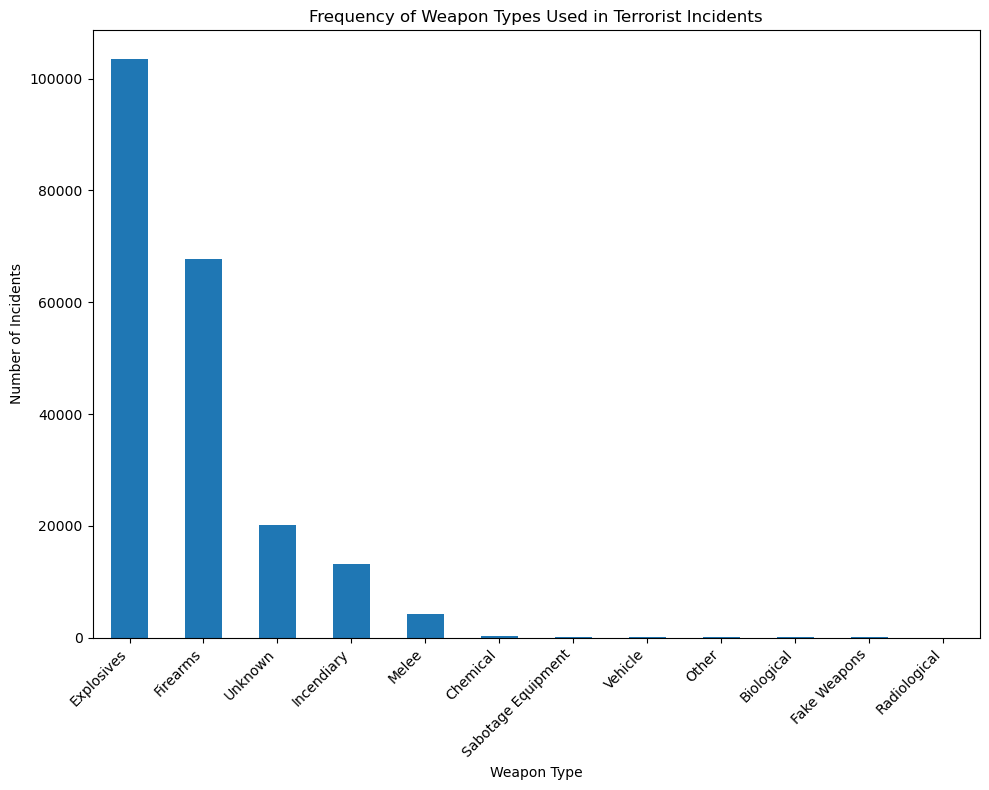

In [14]:
df = pd.read_csv('updated_main_dataset.csv')

weapon_type_dict = {
    1: 'Biological',
    2: 'Chemical',
    3: 'Radiological',
    4: 'Nuclear',
    5: 'Firearms',
    6: 'Explosives',
    7: 'Fake Weapons',
    8: 'Incendiary',
    9: 'Melee',
    10: 'Vehicle',
    11: 'Sabotage Equipment',
    12: 'Other',
    13: 'Unknown'
}

df['weaptype1_txt'] = df['weaptype1'].map(weapon_type_dict)

weapon_type_counts = df['weaptype1_txt'].value_counts()
weapon_type_counts_df = weapon_type_counts.reset_index()
weapon_type_counts_df.columns = ['Weapon Type', 'Frequency']

print(weapon_type_counts_df)

plt.figure(figsize=(10, 8))
weapon_type_counts.plot(kind='bar')
plt.title('Frequency of Weapon Types Used in Terrorist Incidents')
plt.xlabel('Weapon Type')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

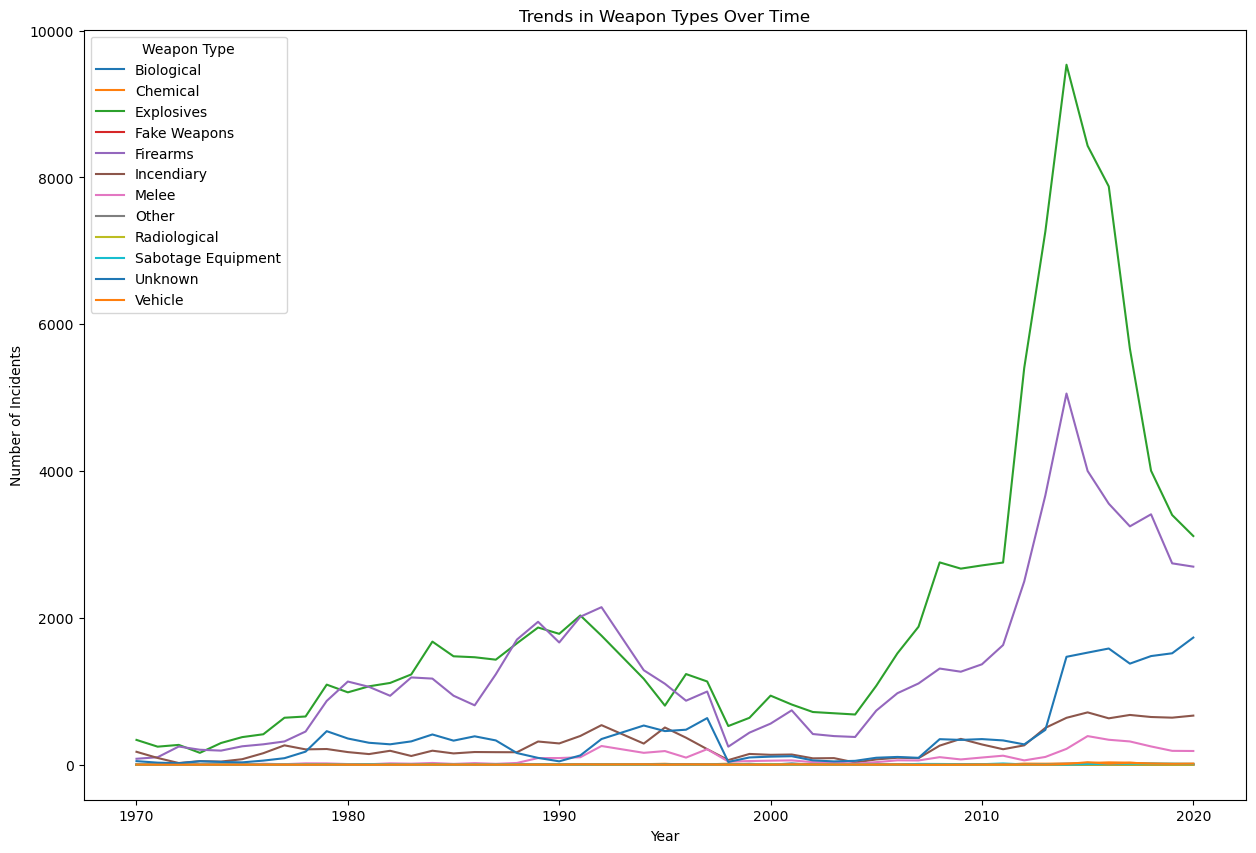

weaptype1_txt  iyear  Biological  Chemical  Explosives  Fake Weapons  \
0               1970           0         3         338             0   
1               1971           0         1         246             0   
2               1972           0         0         270             1   
3               1973           0         4         162             0   
4               1974           0         4         296             1   
5               1975           0         3         376             0   
6               1976           0         3         415             0   
7               1977           0         2         640             0   
8               1978           0         9         657             0   
9               1979           0         4        1091             1   
10              1980           0         2         986             1   
11              1981           2         0        1068             0   
12              1982           0         0        1114          

In [15]:
weapon_trend_pivot = df.pivot_table(index='iyear', columns='weaptype1_txt', aggfunc='size', fill_value=0)

weapon_trend_pivot.plot(figsize=(15, 10))
plt.title('Trends in Weapon Types Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.legend(title='Weapon Type')
plt.show()

weapon_trend_table = weapon_trend_pivot.reset_index()

print(weapon_trend_table)

           Weapon Type  Average Number of Kills
0              Vehicle                17.274194
1              Unknown                 3.633456
2             Firearms                 3.132871
3                Melee                 2.919565
4           Explosives                 1.973334
5             Chemical                 1.919403
6                Other                 1.164179
7           Incendiary                 0.542233
8   Sabotage Equipment                 0.454054
9           Biological                 0.250000
10        Fake Weapons                 0.028571
11        Radiological                 0.000000


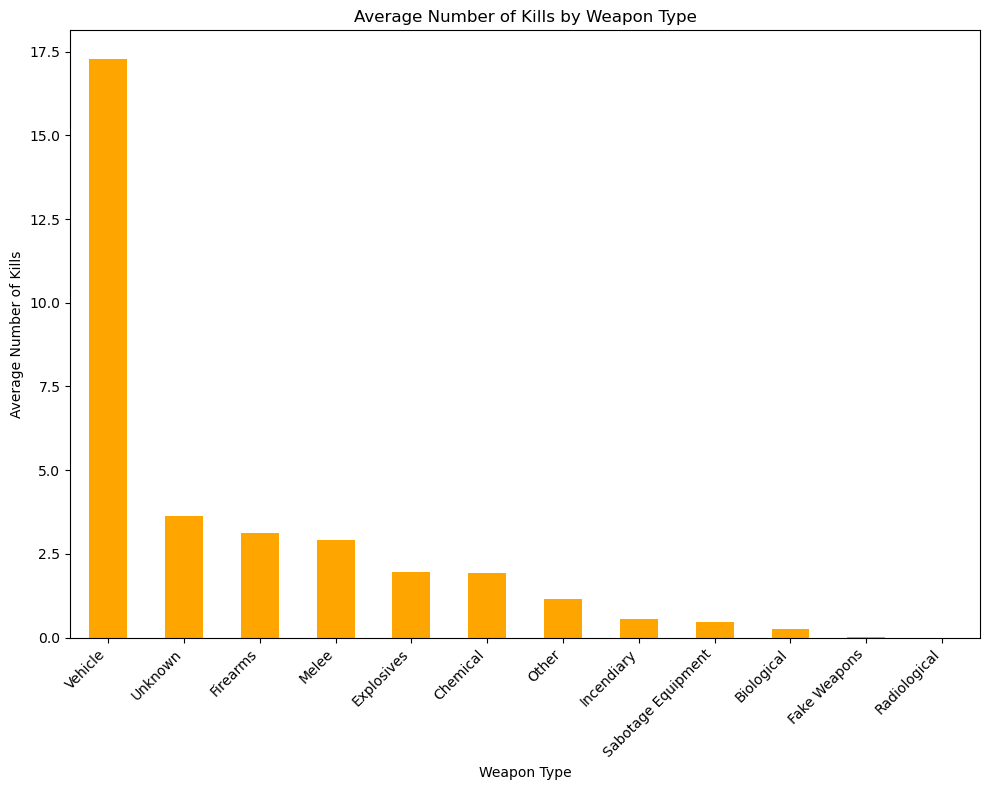

In [16]:
weapon_kills = df.groupby('weaptype1_txt')['nkill'].mean().sort_values(ascending=False)

weapon_kills_df = weapon_kills.reset_index()
weapon_kills_df.columns = ['Weapon Type', 'Average Number of Kills']

print(weapon_kills_df)

plt.figure(figsize=(10, 8))
weapon_kills.plot(kind='bar', color='orange')
plt.title('Average Number of Kills by Weapon Type')
plt.xlabel('Weapon Type')
plt.ylabel('Average Number of Kills')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Network Analysis

In [17]:
df = pd.read_csv('updated_main_dataset.csv')

G = nx.Graph()

groups = df['gname'].unique()
for group in groups:
    if group != 'Unknown':
        G.add_node(group)

for year in df['iyear'].unique():
    for region in df[df['iyear'] == year]['region_txt'].unique():
        groups_in_region = df[(df['iyear'] == year) & (df['region_txt'] == region)]['gname'].unique()
        for (group1, group2) in combinations(groups_in_region, 2):
            if group1 != 'Unknown' and group2 != 'Unknown' and not G.has_edge(group1, group2):
                G.add_edge(group1, group2)

degree_centrality = nx.degree_centrality(G)

threshold = 0.01
filtered_centrality = {k: v for k, v in degree_centrality.items() if v >= threshold}

degree_centrality_df = pd.DataFrame(list(filtered_centrality.items()), columns=['Group', 'Degree Centrality'])
degree_centrality_df.sort_values(by='Degree Centrality', ascending=False, inplace=True)

print(degree_centrality_df.head(50))

/tmp/ipykernel_1025/2708294364.py:1: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('updated_main_dataset.csv')


                                                  Group  Degree Centrality
397                                   Muslim extremists           0.377384
445                                         Separatists           0.341929
662                                           Hezbollah           0.243621
11    Popular Front for the Liberation of Palestine ...           0.241203
735                      Kurdistan Workers' Party (PKK)           0.238249
1401                                          Tribesmen           0.229116
26                                Right-wing extremists           0.222938
46                  Basque Fatherland and Freedom (ETA)           0.216761
29                         Ulster Volunteer Force (UVF)           0.211926
62                        Ulster Freedom Fighters (UFF)           0.211389
467                                              Gunmen           0.210851
85            Corsican National Liberation Front (FLNC)           0.210851
28                       

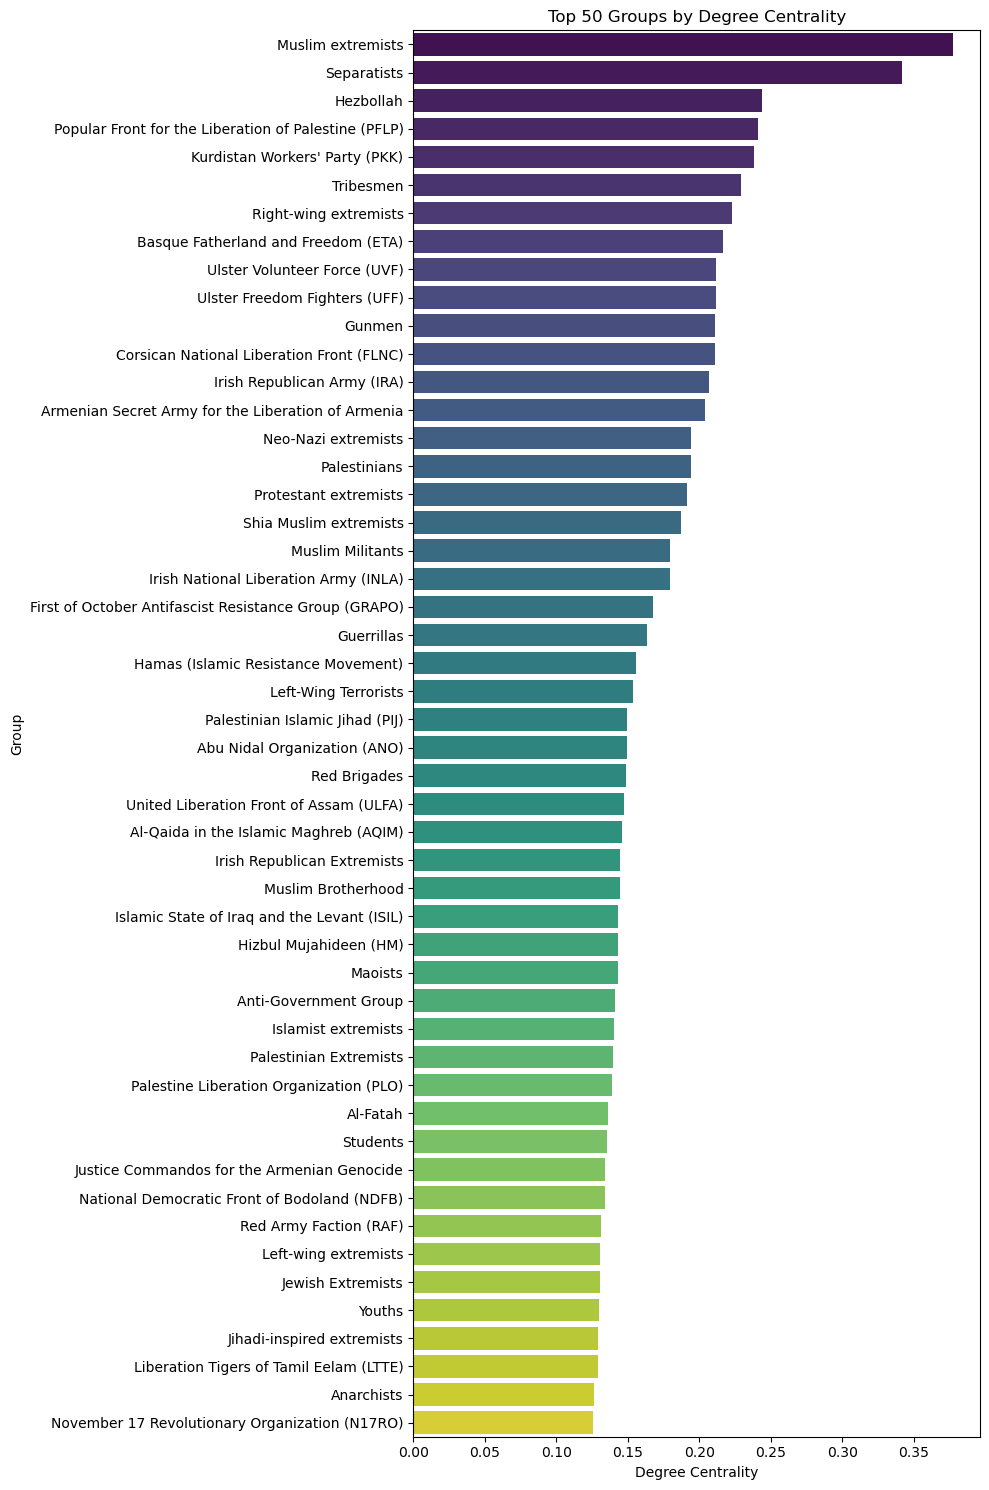

In [18]:
degree_centrality_df = pd.DataFrame(list(degree_centrality.items()), columns=['Group', 'Degree Centrality'])

top_50 = degree_centrality_df.sort_values('Degree Centrality', ascending=False).head(50)

plt.figure(figsize=(10, 15))
sns.barplot(x='Degree Centrality', y='Group', data=top_50, palette='viridis')
plt.title('Top 50 Groups by Degree Centrality')
plt.xlabel('Degree Centrality')
plt.ylabel('Group')
plt.tight_layout()
plt.show()